In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pickle

In [2]:
train_path = '../data/train'
valid_path = '../data/valid'
test_path = '../data/test'

In [3]:
target_size = (224, 224)

# If you get a FileNotFoundError, ensure you've run make in this directory.
train_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
).flow_from_directory(
    train_path, 
    target_size=target_size,
    class_mode='binary'
)
valid_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
).flow_from_directory(
    valid_path, 
    target_size=target_size,
    class_mode='binary'
)
test_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
).flow_from_directory(
    test_path, 
    target_size=target_size,
    class_mode='binary'
)

Found 437 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


In [4]:
index_to_label = {val: key for key, val in train_batches.class_indices.items()}
print(index_to_label)

{0: 'covid', 1: 'normal'}


In [5]:
# Hyperparameters
epochs = 100
learning_rate = 0.0001
dropout_prob_1 = 0.25
dropout_prob_2 = 0.5

# Choosing steps per epoch so that 1 epoch equals 1 pass through train/valid/test (steps = samples / batch_size).
train_batch_size = 32
train_steps = round(train_batches.n / train_batch_size)
valid_batch_size = 32
valid_steps = round(valid_batches.n / valid_batch_size)
test_batch_size = 32
test_steps = round(test_batches.n / test_batch_size)

In [6]:
# Early stopping callback
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

In [7]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(dropout_prob_1),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(dropout_prob_1),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(dropout_prob_1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(dropout_prob_2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
%%script echo "Comment the line with %%script echo to run this cell."
history = model.fit(
    train_batches,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=valid_batches,
    validation_steps=valid_steps,
    callbacks=[es]
)

Comment the line with %%script echo to run this cell.


In [11]:
%%script echo "Comment the line with %%script echo to run this cell."

model.save('arch1.h5')

with open('arch1_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

Comment the line with %%script echo to run this cell.


In [12]:
model = keras.models.load_model('arch1.h5')

with open('arch1_history.pickle', 'rb') as f:
    history = pickle.load(f)

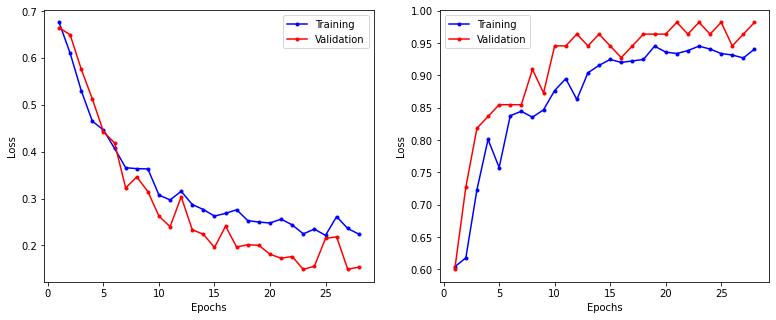

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(np.arange(1, len(history['loss']) + 1), history['loss'], color='b', marker='.', label='Training')
ax[0].plot(np.arange(1, len(history['val_loss']) + 1), history['val_loss'], color='r', marker='.', label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(np.arange(1, len(history['accuracy']) + 1), history['accuracy'], color='b', marker='.', label='Training')
ax[1].plot(np.arange(1, len(history['val_accuracy']) + 1), history['val_accuracy'], color='r', marker='.', label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()